ECE 792 Homework 05

Surya Dutta (SID:200481187)

In [ ]:
# Question 1

In [1]:
!pip install nltk bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=80806e379ea4199444497fda1806973babeaa353d37d36968dd73229351602eb
  Stored in directory: /root/.cache/pip/wheels/73/2b/cb/099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
Successfully built bs4


In [3]:
import nltk
import numpy as np
import re
from nltk.corpus import gutenberg, stopwords
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# download corpus
nltk.download('gutenberg')
nltk.download('stopwords')
corpus = gutenberg.raw('austen-sense.txt')

# Removing all the noise
def denoise_text(text):
    # remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    # replace \n with space
    text = re.sub('\n', ' ', text)
    # remove square brackets
    text = re.sub('\[[^\]]*\]', ' ', text)
    # replace punctuation with space
    text = re.sub(r'[^\w\s]', ' ', text)
    # remove special characters
    text = re.sub(r'[^a-zA-z0-9\s]', ' ', text)
    # replace extra spaces with single space
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

corpus = denoise_text(corpus)
words = corpus.split(' ')
unique_words = np.unique(words)
vocab_size = len(unique_words)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(np.unique(unique_words)):
    idx_to_word[i] = word
    word_to_idx[word] = i

In [7]:
# Generate the sequence 
sequence = [' '.join(words[i:i+6]) for i in range(len(words) - 6 + 1)]

X = []
y = []
for seq in sequence:
    split_seq = seq.split()
    new_list = list(map(lambda word: word_to_idx[word], split_seq[:-1]))
    X.append(new_list)
    y.append(word_to_idx[split_seq[-1]])
X = torch.tensor(X)
y = torch.tensor(y)

In [10]:
class N_gram_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], 
                self.y[idx])
        
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embed(x)
        output, (hidden, _) = self.lstm(x)
        out = self.fc1(hidden.squeeze(0))
        return out

In [12]:
data = N_gram_Dataset(X, y)
data_loader = DataLoader(data, batch_size=128, shuffle=True)

In [14]:
embed_dim = 50
hidden_dim = 100
output_dim = len(word_to_idx)

model = LSTM(len(word_to_idx), embed_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 50
loss_values = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in data_loader:
        input, target = batch
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(data_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch: 1/50, Loss: 6.2351
Epoch: 2/50, Loss: 5.5340
Epoch: 3/50, Loss: 5.2436
Epoch: 4/50, Loss: 5.0404
Epoch: 5/50, Loss: 4.8720
Epoch: 6/50, Loss: 4.7245
Epoch: 7/50, Loss: 4.5879
Epoch: 8/50, Loss: 4.4615
Epoch: 9/50, Loss: 4.3431
Epoch: 10/50, Loss: 4.2305
Epoch: 11/50, Loss: 4.1237
Epoch: 12/50, Loss: 4.0220
Epoch: 13/50, Loss: 3.9244
Epoch: 14/50, Loss: 3.8333
Epoch: 15/50, Loss: 3.7448
Epoch: 16/50, Loss: 3.6601
Epoch: 17/50, Loss: 3.5796
Epoch: 18/50, Loss: 3.5028
Epoch: 19/50, Loss: 3.4277
Epoch: 20/50, Loss: 3.3557
Epoch: 21/50, Loss: 3.2877
Epoch: 22/50, Loss: 3.2211
Epoch: 23/50, Loss: 3.1568
Epoch: 24/50, Loss: 3.0952
Epoch: 25/50, Loss: 3.0355
Epoch: 26/50, Loss: 2.9776
Epoch: 27/50, Loss: 2.9214
Epoch: 28/50, Loss: 2.8674
Epoch: 29/50, Loss: 2.8160
Epoch: 30/50, Loss: 2.7652
Epoch: 31/50, Loss: 2.7164
Epoch: 32/50, Loss: 2.6694
Epoch: 33/50, Loss: 2.6236
Epoch: 34/50, Loss: 2.5803
Epoch: 35/50, Loss: 2.5375
Epoch: 36/50, Loss: 2.4968
Epoch: 37/50, Loss: 2.4569
Epoch: 38/

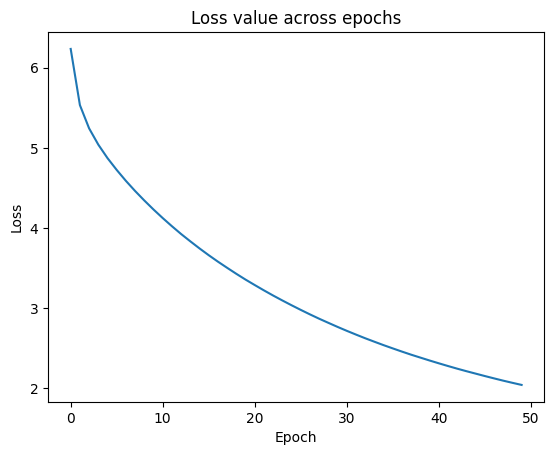

In [15]:
# Plot the loss value across epochs
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss value across epochs")
plt.show()

In [16]:
# Generating predictions for new text
in_text = "his natural shyness was overcome"
generated_text = in_text

for _ in range(100):
    tokenized_input = in_text.split()
    
    if len(tokenized_input) < 5:
        tokenized_input = [""] * (5 - len(tokenized_input)) + tokenized_input

    temp = torch.tensor([word_to_idx[word] for word in tokenized_input[-5:]])

    with torch.no_grad():
        y_pred = torch.argmax(model(temp.unsqueeze(0)), dim=1).item()
    next_word = idx_to_word[y_pred]
    in_text += " " + next_word
    generated_text += " " + next_word

print(generated_text)

his natural shyness was overcome his countenance gave rise to conjectures which might have been more anxious to say than any thing else but i did not know it to be more than he meant by his distress of his mother and mother and marianne was forced to find out as she could not deny the heart was of every thing in the world however in the same little concern for the cottage at the door tomorrow to it but a word and not merely for my own part i am sorry for i was forced to think that she was able to be as


In [17]:
# Question 2

In [6]:
from numpy import array
import networkx as nx
from networkx import read_edgelist, set_node_attributes
import pandas as pd

network = read_edgelist('karate.edgelist.txt',nodetype=int)
attributes = pd.read_csv('karate.attributes.csv', index_col=['node'])
for attribute in attributes.columns.values:
  set_node_attributes(network,values=pd.Series(attributes[attribute],index=attributes.index).to_dict(),name=attribute)

X_train, y_train = map(array, zip(*[([node], data['role'] == 'Administrator') for node, data in network.nodes(data=True) if data['role'] in {'Administrator', 'Instructor'}]))

X_test, y_test = map(array, zip(*[([node], data['community'] == 'Administrator') for node, data in network.nodes(data=True) if data['role'] == 'Member']))


In [13]:
Xtrain_flatten = torch.flatten(torch.from_numpy(X_train))
Xtest_flatten = torch.flatten(torch.from_numpy(X_test))
y_train = torch.from_numpy(y_train).to(torch.float)

In [109]:
import numpy as np
from networkx import shortest_path_length

X_2 = np.zeros((34, 2))
node_distance_instructor = shortest_path_length(network, target = X_train[0][0])

node_distance_administrator = shortest_path_length(network, target = X_train[-1][0])

for node in network.nodes():
  X_2[node][0] = node_distance_administrator[node]
  X_2[node][1] = node_distance_instructor[node]

A = nx.to_numpy_array(network)
A = torch.from_numpy(np.array(A))

In [54]:
class GCN(nn.Module):
    
    def __init__(self,A,input_channels,output_channels,activation = 'tanh'):
        
        super(GCN,self).__init__()
        
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.linear_l1 = nn.Linear(self.input_channels,self.output_channels)
        nn.init.xavier_normal_(self.linear_l1.weight)
        self.activation = nn.Tanh()
      
        I = torch.eye(A.shape[1])
        A_hat = A + I
        A_hat = A_hat.to(torch.double)
       
        diag = torch.diag(torch.pow(torch.sum(A_hat,dim = 0),-0.5),0)
       
        self.A_hat = torch.matmul(torch.matmul(diag,A_hat),diag)
        self.A_hat.requires_grad = False
       
        
    def forward(self,X):
        
        aggregation = torch.matmul(self.A_hat,X)
        linear_out = self.linear_l1(aggregation.to(torch.float))
        prop = self.activation(linear_out)  
        return prop.to(torch.double)

class classification(nn.Module):
    
    def __init__(self,input_channels,output_channels):
        super(classification,self).__init__()
        
        self.Linear = nn.Linear(input_channels,output_channels,bias=True)
        nn.init.xavier_normal_(self.Linear.weight)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,X):
        linear_out = self.Linear(X.to(torch.float))
        return self.sigmoid(linear_out)

In [11]:
identity = torch.eye(A.shape[1])
identity = identity.to(torch.double)
identity.requires_grad = False

In [56]:
hidden_layer = [(4,'tanh'),(2,'tanh')]

class FeatureModel(nn.Module):
    def __init__(self,A,hidden_layer_config,initial_input_size):
        super(FeatureModel,self).__init__()
        self.hidden_layer_config = hidden_layer_config
        
        self.moduleList = list()
        
        self.initial_input_size = initial_input_size
        
        for input_size,activation in hidden_layer_config:
            
            self.moduleList.append(GCN(A,self.initial_input_size,input_size,activation))
            self.initial_input_size = input_size
        
        
        
        self.sequentialModule = nn.Sequential(*self.moduleList)
      
           
    def forward(self,X):
        output = self.sequentialModule(X)
       
        return output

class ClassifierModel(nn.Module):
    def __init__(self,input_channels,output_channels):
        super(ClassifierModel,self).__init__()
        self.logisticRegressor = classification(input_channels=input_channels,output_channels= output_channels)
        
    def forward(self,X):
        
        classified  = self.logisticRegressor(X)
        return classified
    

class FinalModel(nn.Module):
    def __init__(self,A,hidden_layer_config,initial_input_size):
        super(FinalModel,self).__init__()
        self.featureModel = FeatureModel(A,hidden_layer_config,identity.shape[1])
        self.featureModelOutputSize = self.featureModel.initial_input_size
        self.classifier = ClassifierModel(self.featureModelOutputSize,1)
        self.featureModelOutput = None
    
    def forward(self,X):
        
        outputFeature = self.featureModel(X)
        classified = self.classifier(outputFeature)
        self.featureModelOutput = outputFeature
        return classified

In [58]:
model = FinalModel(A,hidden_layer,identity.shape[1])
output = model(identity)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(),lr = 0.01,momentum=0.9)
featureoutput = None

In [63]:
def train(model, epochs, criterion, optimizer, feature, plot_epochs=[]):
    losses = []
    tst_outputs = []
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for i, node in enumerate(Xtrain_flatten):
            optimizer.zero_grad()
            out = model(feature)[node].unsqueeze(0)
            ground_truth = torch.reshape(y_train[i], out.shape)
            loss = criterion(out, ground_truth)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss)

        if epoch in plot_epochs:
            with torch.no_grad():
                test_out = model(feature)[Xtest_flatten]
                tst_outputs.append((epoch, test_out))
                
    return losses, tst_outputs

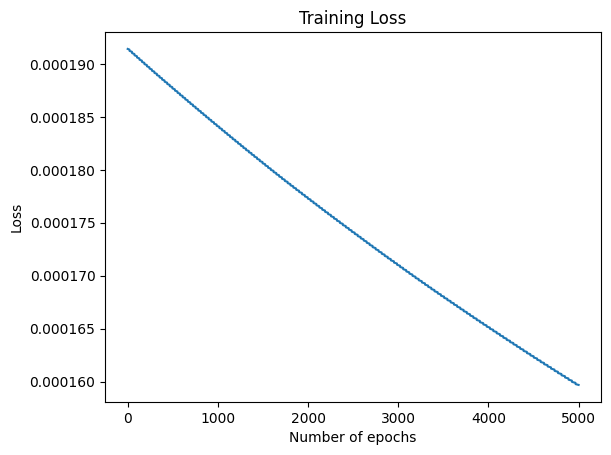

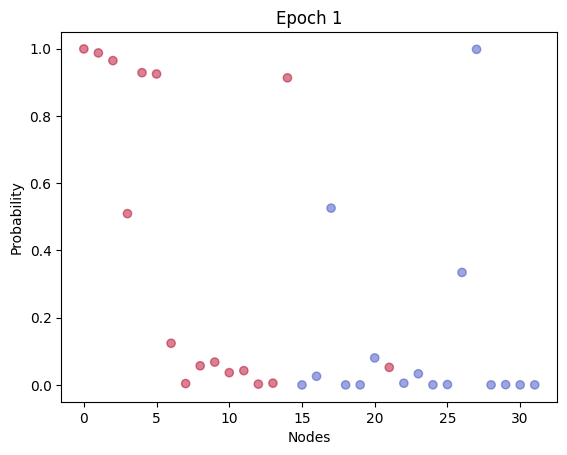

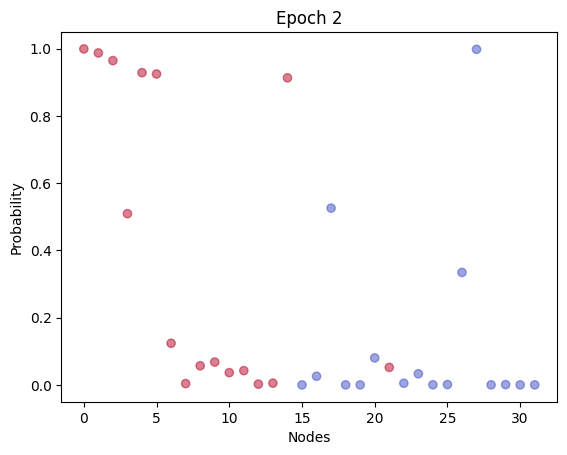

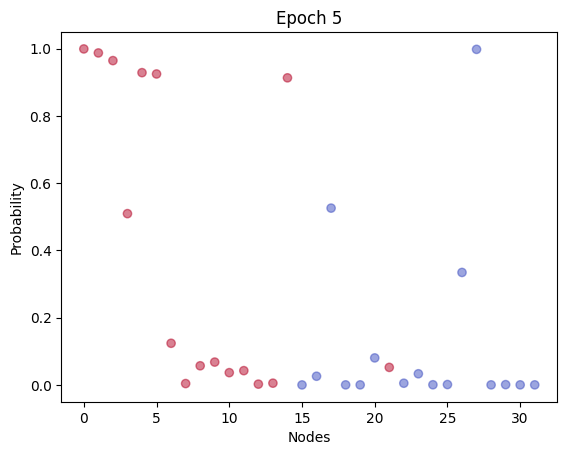

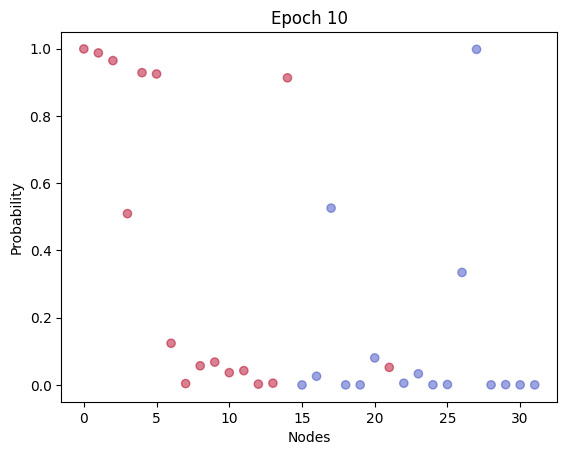

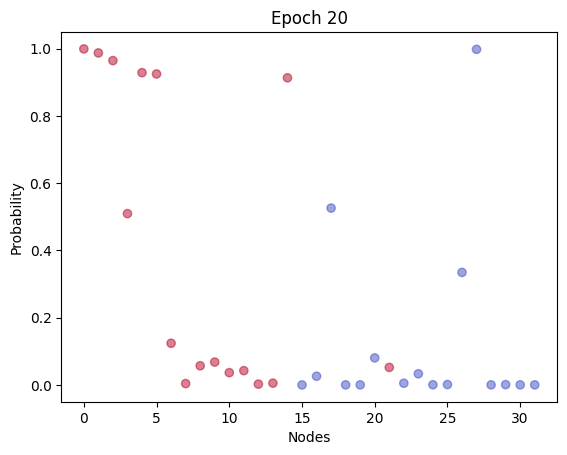

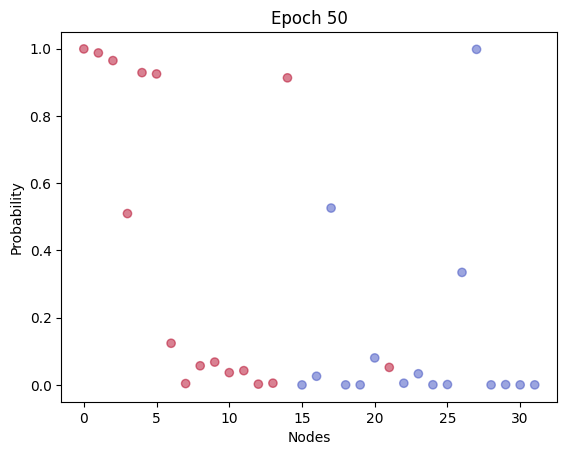

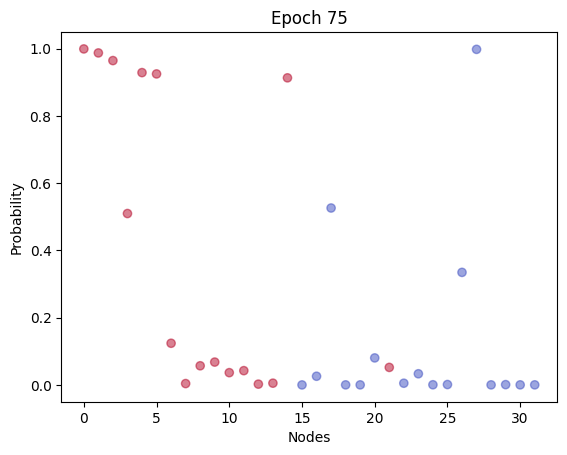

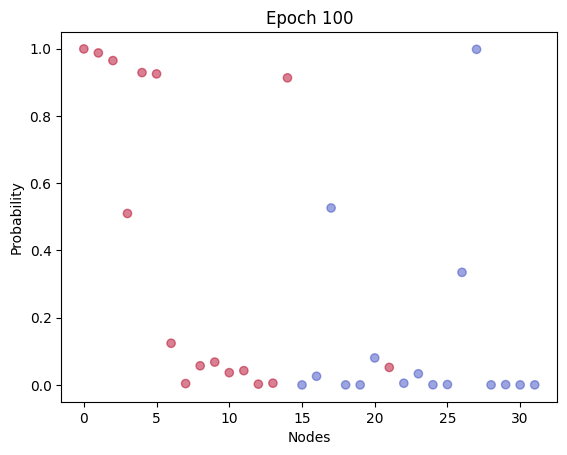

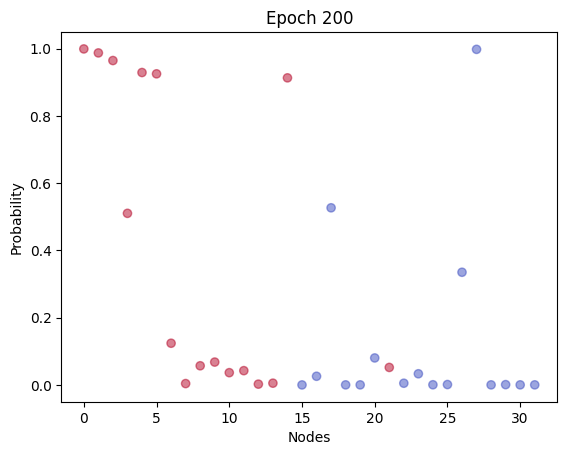

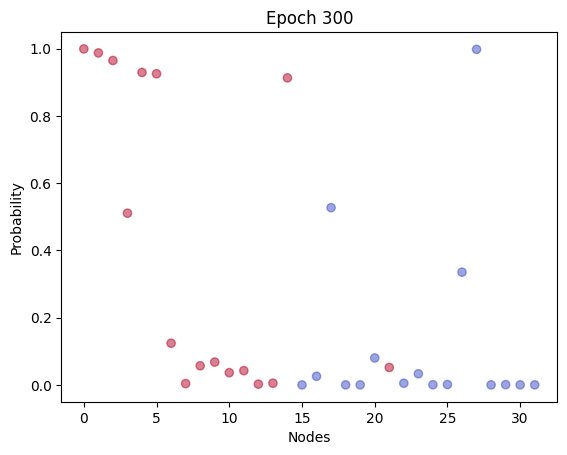

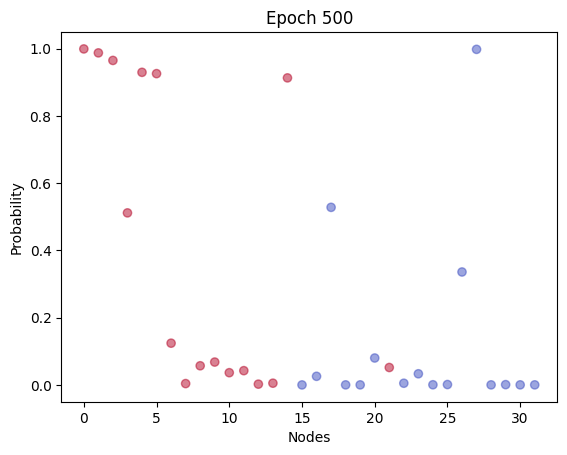

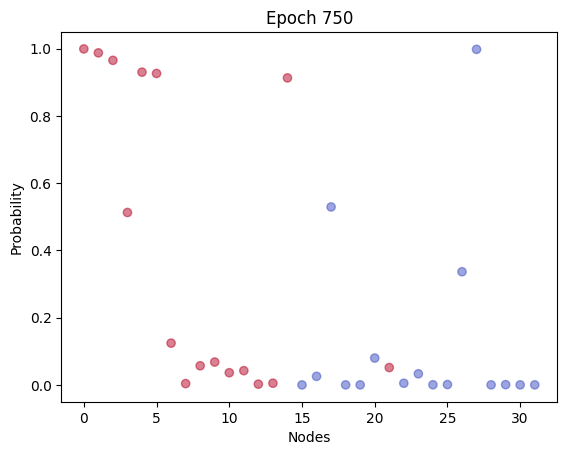

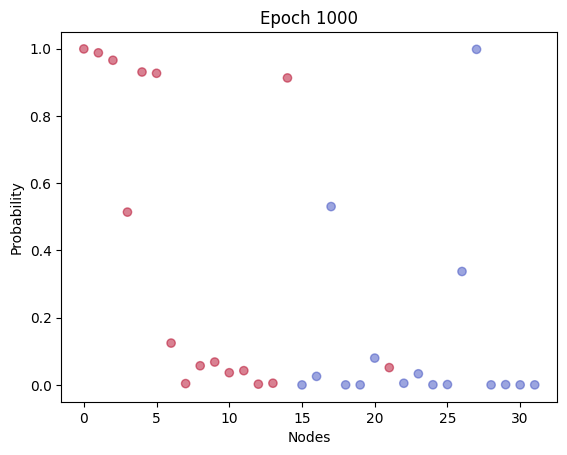

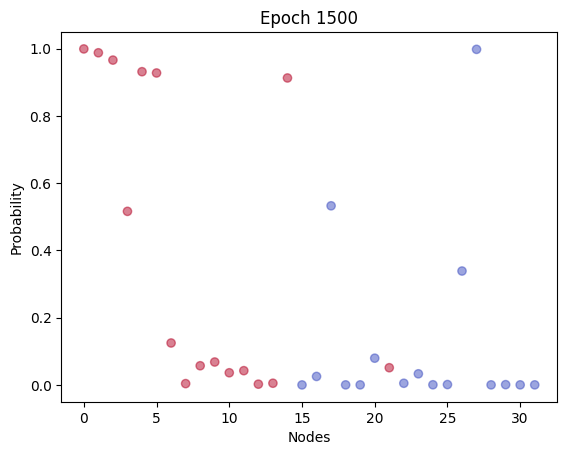

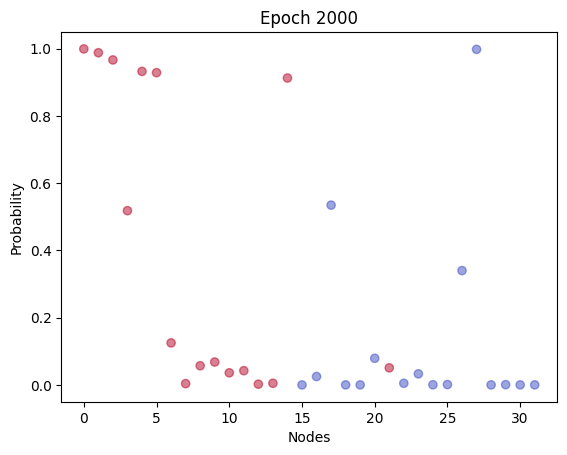

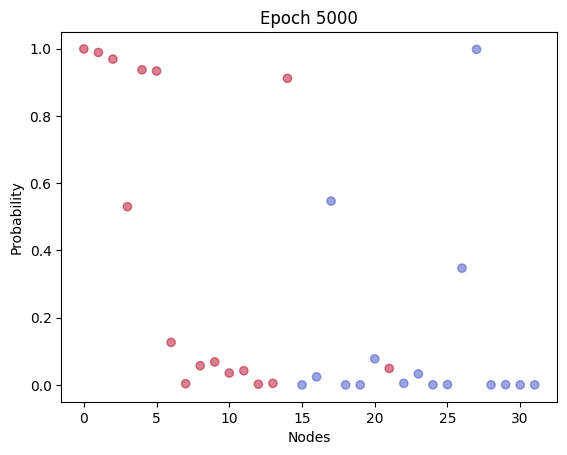

In [69]:
epochs = 5000
plt_epochs = [1, 2, 5, 10, 20, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 5000]
losses, tst_outputs = train(model, epochs, criterion, optimizer, identity, plt_epochs)

plt.plot(range(1, epochs+1), losses)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

for epoch, tst_output in tst_outputs:
    tst_output_1d = tst_output.flatten()
    
    fig, ax = plt.subplots()
    scatter = ax.scatter(range(len(tst_output_1d)), tst_output_1d, c=y_test, cmap='coolwarm', alpha=0.5)
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Probability')
    plt.show()


In [77]:
# How does prediction compare with actual class memberships
y_test = torch.tensor(y_test, dtype=torch.float)
correct = (tst_output == y_test.unsqueeze(1)).sum().item()
accuracy = correct / len(y_test)

<ipython-input-77-4f466ae1167a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float)


In [ ]:
# Question 3

In [7]:
import networkx as nx
from networkx import read_edgelist, set_node_attributes
import torch.nn.functional as F

# Feature extraction
X2 = np.zeros((34, 2))
node_distance_administrator = nx.shortest_path_length(network, target=X_train[0][0])
node_distance_instructor = nx.shortest_path_length(network, target=X_train[-1][0])

for node in network.nodes():
    X2[node][0] = node_distance_administrator[node]
    X2[node][1] = node_distance_instructor[node]

A = nx.to_numpy_array(network)
A = torch.from_numpy(np.array(A))

In [8]:
# GAT Layer
class GATLayer(nn.Module):
    def __init__(self, input_features, output_features):
        super(GATLayer, self).__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.W = nn.Linear(input_features, output_features, bias=False)
        self.a = nn.Linear(2 * output_features, 1, bias=False)
        #self.dropout = dropout
        #self.concat = concat

    def forward(self, h, A):
      Wh = self.W(h) 
      N = h.size(0)
      a_input = torch.cat([Wh.unsqueeze(1).expand(-1, N, -1), Wh.unsqueeze(0).expand(N, -1, -1)], dim=2)
      e = F.leaky_relu(self.a(a_input).squeeze(2))
      zero_vec = -9e15 * torch.ones_like(e)
      att = torch.where(A.bool(), e, zero_vec)
      att = F.softmax(att, dim=1)
      h_prime = torch.matmul(att, Wh)
      return h_prime

In [9]:
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GAT, self).__init__()
        self.att1 = GATLayer(nfeat, nhid)
        self.att2 = GATLayer(nhid, nhid)
        self.dropout = dropout
        self.classifier = nn.Linear(nhid, 1)

    def forward(self, x, A):
        x = F.dropout(x.float(), self.dropout, training=self.training)
        x = F.elu(self.att1(x, A))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.att2(x, A)
        x = self.classifier(x)
        return F.sigmoid(x)


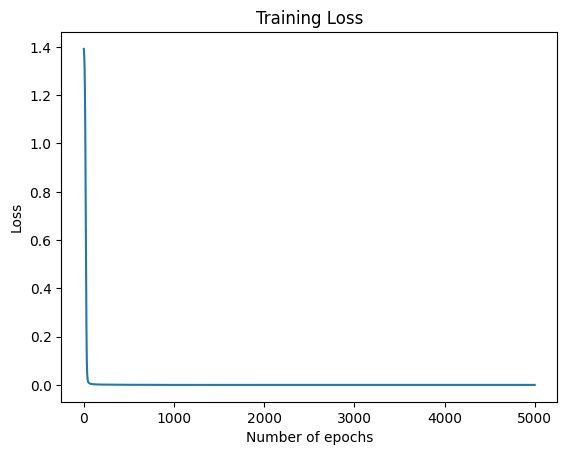

In [14]:
model2 = GAT(nfeat=identity.shape[1], nhid=8, nclass=2, dropout=0.6)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.005, weight_decay=5e-4)

def train2(model, epoch, loss_fn, optimizer, feature, plot_epochs):
    model.train()
    cum_loss = 0
    losses = []
    tst_outputs = []

    for j in range(epoch):
        epoch_loss = 0

        for i, node in enumerate(Xtrain_flatten):
            optimizer.zero_grad()
            output = model(feature, A)[node].unsqueeze(0)
            ground_truth = torch.reshape(y_train[i], output.shape).float()
            loss = loss_fn(output, ground_truth)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss)
        cum_loss += epoch_loss

        if j + 1 in plot_epochs:
            model.eval()
            test_output = model(identity, A)[Xtest_flatten].detach().numpy()
            tst_outputs.append((j + 1, test_output))

    plt.plot(losses)
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    return tst_outputs

tst_outputs = train2(model2, 5000, loss_fn, optimizer, identity, plot_epochs=[1, 2, 5, 10, 20, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 5000])

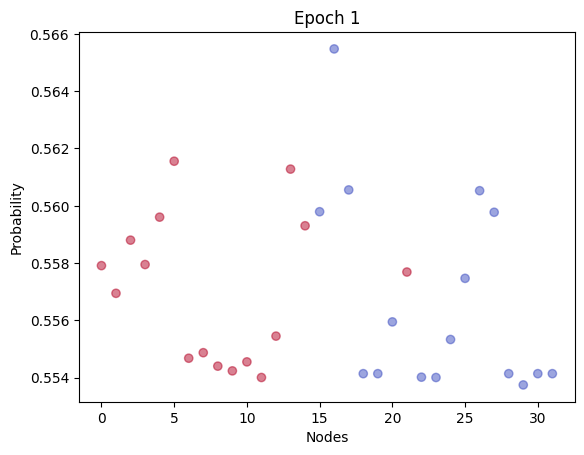

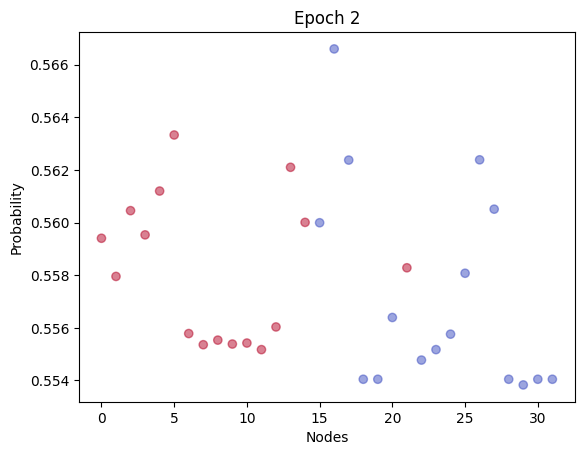

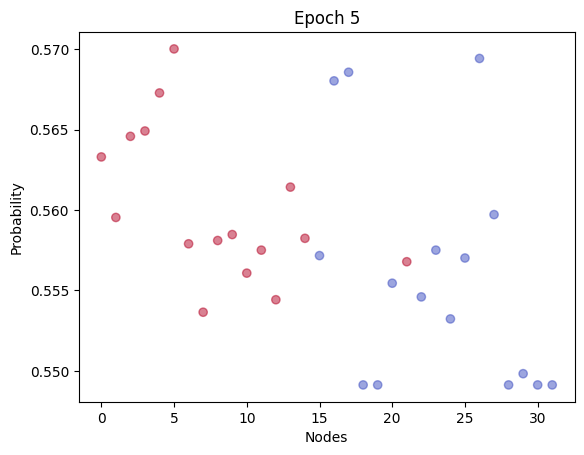

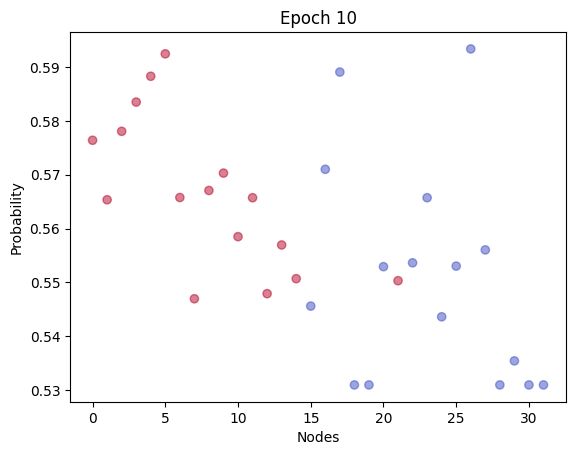

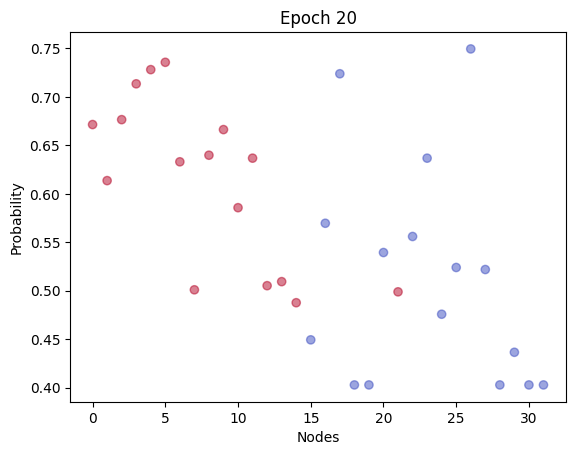

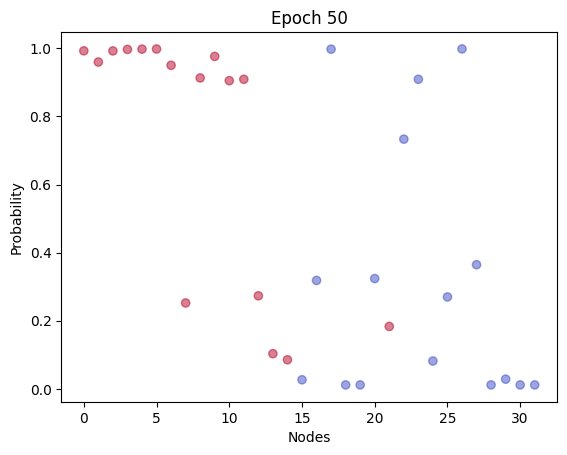

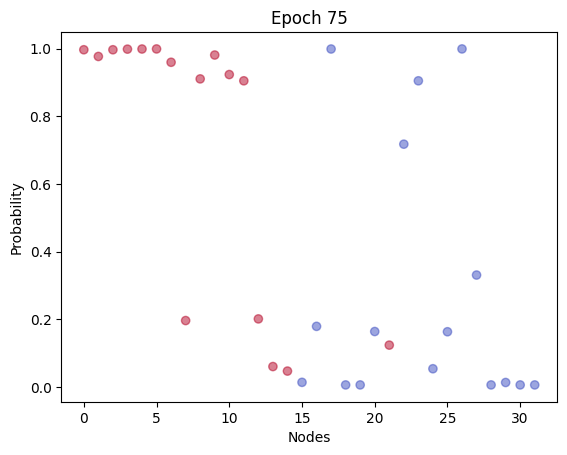

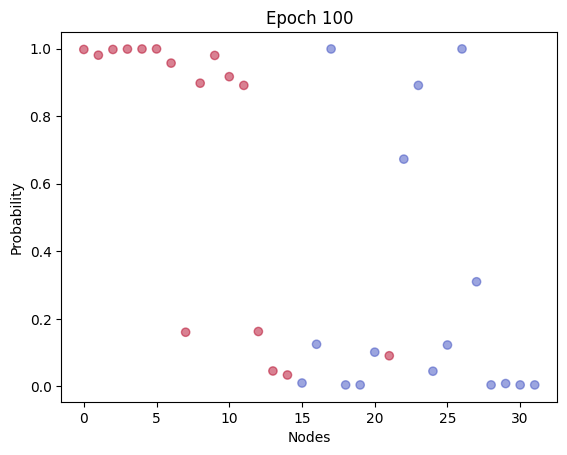

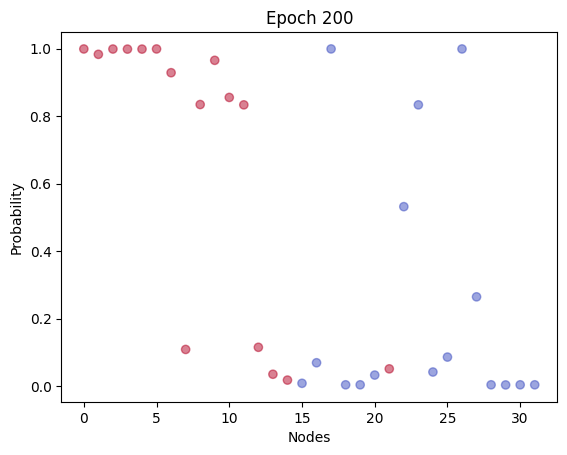

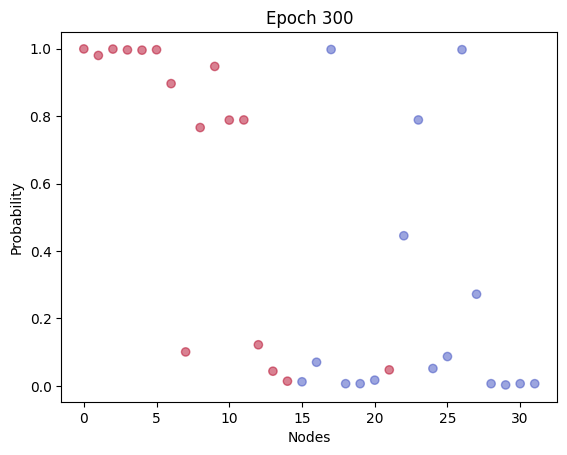

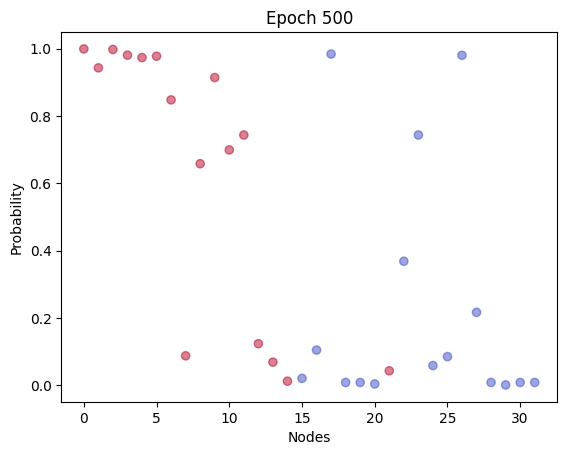

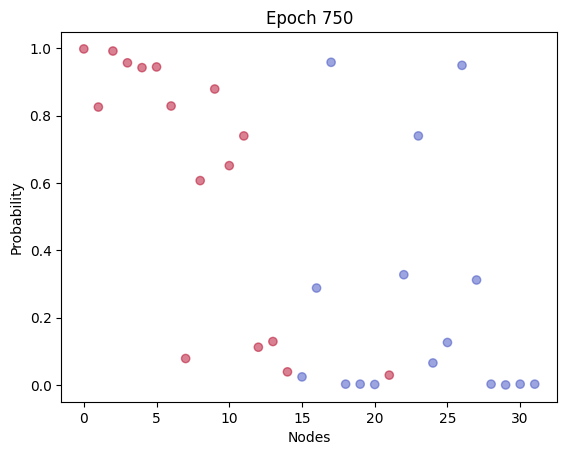

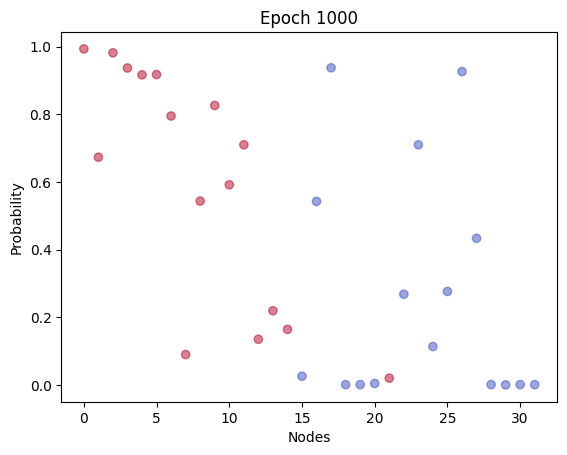

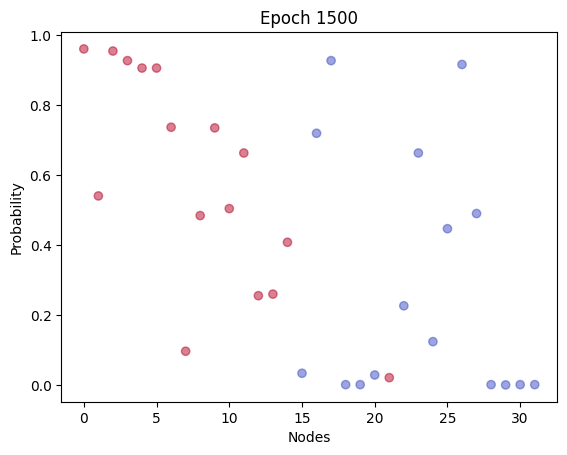

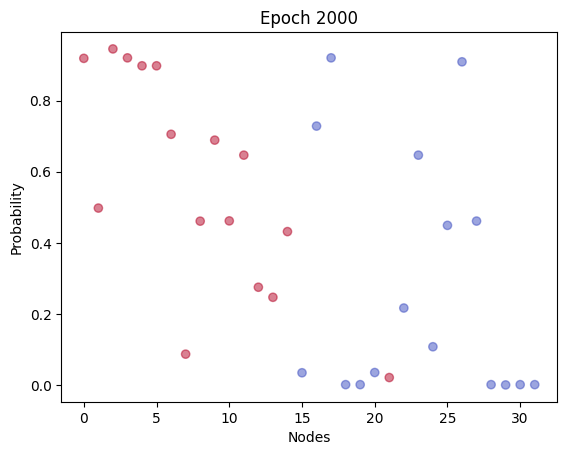

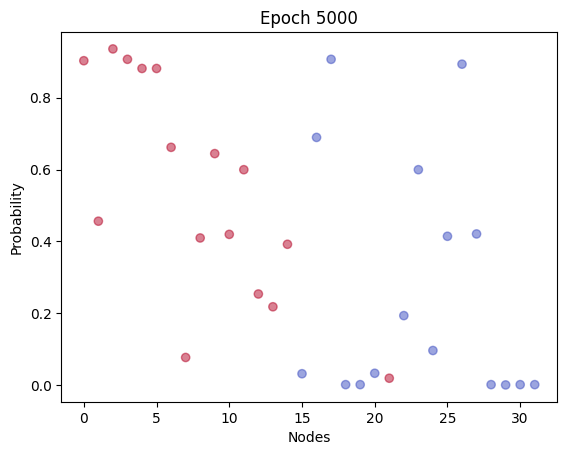

In [15]:
for epoch, tst_output in tst_outputs:
    tst_output_1d = tst_output.flatten()
    
    fig, ax = plt.subplots()
    scatter = ax.scatter(range(len(tst_output_1d)), tst_output_1d, c=y_test, cmap='coolwarm', alpha=0.5)
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Probability')
    plt.show()

In [ ]:
# How does prediction compare with actual class memberships
y_test = torch.tensor(y_test, dtype=torch.float)
correct = (tst_output == y_test.unsqueeze(1)).sum().item()
accuracy = correct / len(y_test)